# <font color='darkorchid'>Default Canteen</font>
<font color = 'slategray' > This notebook provides an example setup for a default reservoir and simulation using the Canteen package. This is the best staring place for new users. It covers the package's major data structures and overall simulation process, but not how the various data structures are parameterized. Other example notebooks (i.e. wilson.ipynb) cover the paramterizaiton process in more detail.  </font>

by: John Kucharski | 22 March 2021

In [1]:
import sys
from datetime import datetime

In [2]:
sys.path.insert(0, '/Users/johnkucharski/Documents/source/canteen')
from src.data import Category, Input, TimeStep, TimeSeries
from src.reservoir import Reservoir
import src.operations as operations 
from src.simulation import Simulation

# <font color=salmon> Input </font>

<font color=slategray> Data for reservoir simulations are contained in a list of _Input_ objects. Other example notebooks (i.e. wilson.ipynb) demonstrate how these data can be read in from external files (i.e. *.csv files). In this example notebook, a list is generated using the default _Input_ object constructor. This constructor takes the following arguments:

* _date_: a datetime for the time step. 
* _inflow_: a float inflow value, for each time step.
* _storage_ (optional): a float volume of storage at the reservoir at the beginning of the timestep. 
* _additional_inputs_ (optional): Dict[str, Additional_Input]: an optional argument that allows for any other relevant input (i.e. temperature, etc.) to be used in the simulation.

In this case the simulation will run for 4 days from January 1, 2000 to January 4, 2000, a sequence of inflows [1, 1, 2, 0] are provide along with an initial storage volume of 0 (storage volumes will be computed for the following timesteps). No optional additional inputs are provided.

In [3]:
inputs = TimeSeries(timesteps=[
    TimeStep(datetime(2000, 1, 1), inputs={'inflow': Input(1), 'storage': Input(0, category=Category.STORAGE)}),
    TimeStep(datetime(2000, 1, 2), inputs={'inflow': Input(1)}),
    TimeStep(datetime(2000, 1, 3), inputs={'inflow': Input(2)}),
    TimeStep(datetime(2000, 1, 4), inputs={'inflow': Input(0)}),
    TimeStep(datetime(2000, 1, 5), inputs={'inflow': Input(0)})])
[input.print() for input in inputs.timesteps]

['01 Jan 2000 (inflow: 1, storage: 0)',
 '02 Jan 2000 (inflow: 1)',
 '03 Jan 2000 (inflow: 2)',
 '04 Jan 2000 (inflow: 0)',
 '05 Jan 2000 (inflow: 0)']

# <font color='salmon'>Reservoir</font>

A reservoir in the canteen program is made up of the following items:
* a <i>capacity</i> and <i>bottom</i> volume
* a list of <i>outlets</i>
* a dictionary functional <i>maps</i> linking volumetric locations to named variables
* a <i>name</i>

A default reservoir can be created with a single line of code.

In [4]:
default_canteen = Reservoir()
default_canteen.print()

'default(capacity: 1, outlets: [spill(location: 1.0)], mapped variables: [None])'

By default the reservoir <i>capacity</i> = 1, a single spillway <i>outlet</i> is constructed, no <i>maps</i> are provided and the <i>name</i> of the reservoir is 'default'. These attributes are visable using the <i>reservoir</i> object's <i>print()</i> command.

# <font color='salmon'>Operations</font>

<font color=slategray> Operations are functions applied to the reservoir during a simulation. They are defined seperately and are not part of the _Reservoir_ object. In the _canteen_ package an operations function must (at a minimum) accept the following arguments:

* _input_: a _data.Input_ object containing at a minimum: a _date_, and an _inflow_. The _input_ object is discussed above.
* _outlets_: reservoir outlets, as described above.
 
The operations function must return a _Dict[str, float]_ that describes the release from each of the  _outlets_ provided in the function inputs.

Some basic reservoir operations functions used to identify: target reservoir volumes (such as rule curves), target releases (such as maximum flood safe outflows and hedging rules) and releases made from each <i>outlet</i> are provided as part of the operations package. However, reservoir operations for simulation models are generally constructed from user defined functions. 

The defalut canteen's operations will be driven by the _passive_operations()_ function in the _operations_ module. This function is copied below.

```python
def passive_operations(input: data.Input, outlets: typing.List[outlet.Outlet]) -> typing.Dict[str, float]:
    releases = {}
    outlets.sort(key=lambda x: x.location)
    stored, released = input.storage + input.inflow, 0
    for x in outlets:
        released += x.max_release(stored)
        releases[x.name] = released
        stored -= released
    return releases
```

It causes the reservoir to release water that can be released (and therefore store water that cannot be released). Since the default canteen has only one spillway at the top of the reservoir (at its capacity volume of 1) the reservoir will only make spilled releases.

# <font color='salmon'>Simulation</font>

<font color=slategray>To start a simulation the required components:
* _inputs_: List[Input] (described above),
* _reservoir_: Reservoir (described above),
* _operate_function_: Callable[[Input, List[Outlet], Dict[str, float]] (described above),
* _additional_outputs_ (optional): Dict[str, Additional_Output] (described in other examples, i.e. Wilson.ipynb)

are assembled in a Simulation object. The simulate() function runs the simulation. To view the results as a dataframe, the simulate_to_dataframe() function is used below.

In [6]:
default_simulation = Simulation(inputs, default_canteen, operations.passive_operations)
results = default_simulation.simulate()
[t.print() for t in results.timesteps]

['01 Jan 2000 (inflow: 1, storage: 0, spill: 0)',
 '02 Jan 2000 (inflow: 1, storage: 1, spill: 1.0)',
 '03 Jan 2000 (inflow: 2, storage: 1.0, spill: 2.0)',
 '04 Jan 2000 (inflow: 0, storage: 1.0, spill: 0)',
 '05 Jan 2000 (inflow: 0, storage: 1.0, spill: 0)']

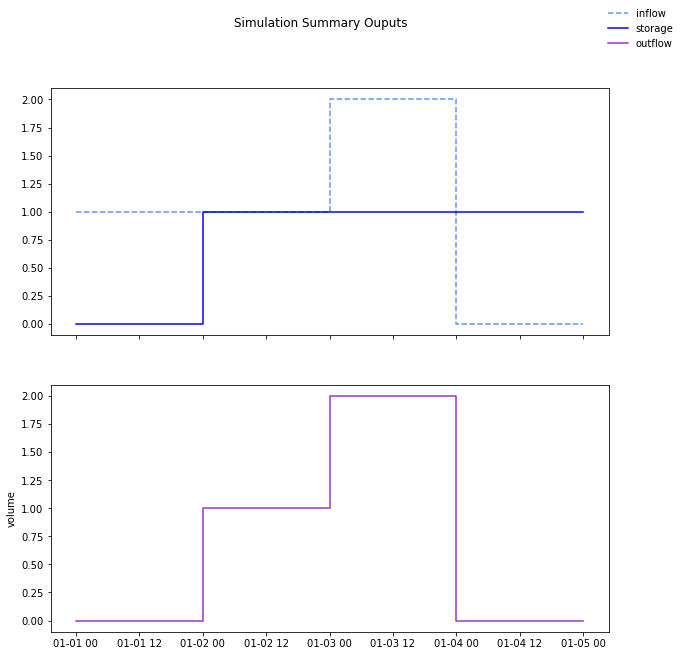

In [7]:
results.plot()